In [1]:
# change root path one level up
import os
os.chdir("..")

In [2]:
# lightgbm and optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pytz
import time
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

CAT_FEATURES = []
NUM_FEATURES = [
    "connectionTime_hour_x",
    "connectionTime_hour_y",
    "connectionTime_month_x",
    "connectionTime_month_y",
    "connectionTime_weekday_x",
    "connectionTime_weekday_y",
]
TARGET = "kWhDelivered"


In [3]:
sessions = pd.read_csv("./data/caltech_test_data.csv", index_col=[0, 1])
# drop idle_time column
sessions = sessions.drop(
    columns=["idle_time", "Requested_parking_time", "parking_time"]
)
for cols in CAT_FEATURES:
    sessions[cols] = sessions[cols].astype("category")
sessions = sessions[NUM_FEATURES + CAT_FEATURES + [TARGET]]
sessions


connectionTime_hour_x  \
connection_time_copy _id                                               
2018-04-30           5bc915caf9af8b0dad3c0660          -5.000000e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb          -2.588190e-01   
2018-05-11           5bc9190ff9af8b0dc677b9c1          -5.000000e-01   
2018-05-14           5bc919c3f9af8b0dc677ba32           8.770390e-14   
                     5bc919c3f9af8b0dc677ba62          -2.588190e-01   
...                                                              ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc          -7.071068e-01   
                     5e1fbc9ff9af8b5391bcd700          -1.000000e+00   
2019-12-31           5e210e1ff9af8b57bb4f54fa          -5.000000e-01   
                     5e210e1ff9af8b57bb4f54fd          -9.659258e-01   
                     5e210e1ff9af8b57bb4f5500           1.133298e-14   

                                               connectionTime_hour_y  \
connection_time_copy _id                                               
2018-04-30           5bc915caf9af8b0dad3c0660           8.660254e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb           9.659258e-01   
2018-05-11           5bc9190ff9af8b0dc677b9c1           8.660254e-01   
2018-05-14           5bc919c3f9af8b0dc677ba32           1.000000e+00   
                     5bc919c3f9af8b0dc677ba62          -9.659258e-01   
...                                                              ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc           7.071068e-01   
                     5e1fbc9ff9af8b5391bcd700          -9.512791e-14   
2019-12-31           5e210e1ff9af8b57bb4f54fa           8.660254e-01   
                     5e210e1ff9af8b57bb4f54fd           2.588190e-01   
                     5e210e1ff9af8b57bb4f5500          -1.000000e+00   

                                               connectionTime_month_x  \
connection_time_copy _id                                                
2018-04-30           5bc915caf9af8b0dad3c0660                0.892254   
2018-05-07           5bc917d0f9af8b0dc677b8bb                0.565554   
2018-05-11           5bc9190ff9af8b0dc677b9c1               -0.232105   
2018-05-14           5bc919c3f9af8b0dc677ba32               -0.742684   
                     5bc919c3f9af8b0dc677ba62               -0.802694   
...                                                               ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc                0.968119   
                     5e1fbc9ff9af8b5391bcd700                0.974267   
2019-12-31           5e210e1ff9af8b57bb4f54fa                0.998482   
                     5e210e1ff9af8b57bb4f54fd                0.999571   
                     5e210e1ff9af8b57bb4f5500                0.999519   

                                               connectionTime_month_y  \
connection_time_copy _id                                                
2018-04-30           5bc915caf9af8b0dad3c0660               -0.451533   
2018-05-07           5bc917d0f9af8b0dc677b8bb                0.824711   
2018-05-11           5bc9190ff9af8b0dc677b9c1                0.972691   
2018-05-14           5bc919c3f9af8b0dc677ba32                0.669642   
                     5bc919c3f9af8b0dc677ba62                0.596391   
...                                                               ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc               -0.250491   
                     5e1fbc9ff9af8b5391bcd700               -0.225399   
2019-12-31           5e210e1ff9af8b57bb4f54fa               -0.055088   
                     5e210e1ff9af8b57bb4f54fd               -0.029276   
                     5e210e1ff9af8b57bb4f5500                0.030998   

                                               connectionTime_weekday_x  \
connection_time_copy _id                                                  
2018-04-30           5bc915caf9af8b0dad3c0660              9.555728e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb   

In [4]:
# find dates 30, 60, 120, 240, 360, 480, 600 days before 2020-12-01 and make a list of them
dates = []
for i in [30, 60, 120, 240, 360, 480]:
    dates.append((datetime(2019, 12, 1) - timedelta(days=i)).strftime("%Y-%m-%d"))
dates


['2019-11-01',
 '2019-10-02',
 '2019-08-03',
 '2019-04-05',
 '2018-12-06',
 '2018-08-08']

In [5]:
# make 6 partitions for training starting with dates[i] and ending with datetime(2020, 12, 1)
train_sessions = []
for i in range(len(dates)):
    train_sessions.append(sessions.loc[dates[i] : "2019-12-01"])
    # print number of sessions in each partition
    print(train_sessions[i].shape)


(196, 7)
(403, 7)
(910, 7)
(2127, 7)
(3627, 7)
(4779, 7)


In [6]:
# testing data is collected from Dec. 1, 2018 to Jan. 1, 2019
test = sessions.loc[(slice("2019-12-01", "2020-01-01"), slice(None)), :]
# print test size
print(test.shape)


(157, 7)


In [7]:
def train_lgb(train, params, num_rounds=200, early_stopping_rounds=10):
    # create lgb datasets
    train_data = lgb.Dataset(
        train.drop(columns=[TARGET]),
        label=train[TARGET],
        categorical_feature=CAT_FEATURES,
    )
    # train model
    model = lgb.train(params, train_data, num_rounds, verbose_eval=False)
    return model


# optimize hyperparameters of lightgbm model using optuna
def objective(trial, train_opt, val_opt):
    # define hyperparameters
    params = {
        "objective": "regression_l1",
        "metric": "mae",
        "verbose": -1,
        "seed": 42,
        "num_leaves": trial.suggest_int("num_leaves", 2, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "min_data": trial.suggest_int("min_data", 1, 100),
        # regularization
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 1e3),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 1e3),
    }
    # train model
    model = train_lgb(
        train_opt, params, num_rounds=200, early_stopping_rounds=10
    )
    # predict on validation set
    y_pred = model.predict(val_opt.drop(columns=[TARGET]))
    # calculate mae
    mae = np.mean(np.abs(val_opt[TARGET] - y_pred))
    return mae


def run_hp(train, n_trials=100):
    train_opt = train.copy()
    # keep 20% of training data from the end for validation
    val_opt = train.iloc[-int(0.2 * len(train)) :].copy()
    # time the training
    start = time.time()
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_opt, val_opt)
    # optimize hyperparameters
    study = optuna.create_study(direction="minimize")
    study.optimize(func, n_trials=n_trials)
    # print best hyperparameters
    print("Best hyperparameters: ", study.best_params)
    # train model with best hyperparameters
    model = train_lgb(
        train, study.best_params, num_rounds=200, early_stopping_rounds=10
    )
    log_time = time.time() - start
    # print time taken to train
    print("Time taken to train: ", time.time() - start)
    del train_opt, val_opt
    return model, log_time


In [8]:
# train model with best hyperparameters
model_0, t_0 = run_hp(train_sessions[0], n_trials=100)
model_1, t_1 = run_hp(train_sessions[1], n_trials=100)
model_2, t_2 = run_hp(train_sessions[2], n_trials=100)
model_3, t_3 = run_hp(train_sessions[3], n_trials=100)
model_4, t_4 = run_hp(train_sessions[4], n_trials=100)
model_5, t_5 = run_hp(train_sessions[5], n_trials=100)

[I 2023-05-16 10:52:09,236] A new study created in memory with name: no-name-1c4572e5-d21c-4aee-b6e9-4fb23a7d19f2
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[W 2023-05-16 10:52:09,290] Trial 0 failed because of the following error: NameError("name 'val_0' is not defined")
Traceback (most recent call last):
  File "/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(

NameError: name 'val_0' is not defined

In [43]:
# print times
print("Time taken to train model 0: ", t_0)
print("Time taken to train model 1: ", t_1)
print("Time taken to train model 2: ", t_2)
print("Time taken to train model 3: ", t_3)
print("Time taken to train model 4: ", t_4)
print("Time taken to train model 5: ", t_5)

Time taken to train model 0:  9.82616901397705
Time taken to train model 1:  11.952608108520508
Time taken to train model 2:  19.197765827178955
Time taken to train model 3:  11.210629940032959
Time taken to train model 4:  26.271372079849243
Time taken to train model 5:  27.268553256988525


In [44]:
# test model on test data
def test_lgb(model, test):
    # time the testing
    start = time.time()
    # test model
    y_pred = model.predict(test.drop(columns=[TARGET]))
    y_true = test[TARGET]
    # print time taken to test
    print("Time taken to test: ", time.time() - start)
    return y_pred, y_true


def test_lgb_timed(model, test, n_iters=20):
    runtime_list = []
    for i in range(n_iters):
        # time the testing
        start = time.time()
        # test model
        y_pred = model.predict(test.drop(columns=[TARGET]))
        y_true = test[TARGET]
        # print time taken to test
        runtime_list.append(time.time() - start)
    print(np.mean(runtime_list))
    return y_pred, y_true


In [45]:
y_pred_0, y_true_0 = test_lgb_timed(model_0, test)
y_pred_1, y_true_1 = test_lgb_timed(model_1, test)
y_pred_2, y_true_2 = test_lgb_timed(model_2, test)
y_pred_3, y_true_3 = test_lgb_timed(model_3, test)
y_pred_4, y_true_4 = test_lgb_timed(model_4, test)
y_pred_5, y_true_5 = test_lgb_timed(model_5, test)


0.001707005500793457
0.001246798038482666
0.0009693503379821777
0.0011130452156066894
0.0011468768119812013
0.0012296557426452637


In [46]:
# evaluate smape of lightgbm model
def smape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + y_pred))) * 100


def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


# evaluate smape for each time interval

print("smape for time interval 0: ", smape(y_true_0.values, y_pred_0))
print("smape for time interval 1: ", smape(y_true_1.values, y_pred_1))
print("smape for time interval 2: ", smape(y_true_2.values, y_pred_2))
print("smape for time interval 3: ", smape(y_true_3.values, y_pred_3))
print("smape for time interval 4: ", smape(y_true_4.values, y_pred_4))
print("smape for time interval 5: ", smape(y_true_5.values, y_pred_5))


smape for time interval 0:  47.8497231935743
smape for time interval 1:  45.87554516354613
smape for time interval 2:  45.33516855799545
smape for time interval 3:  45.5160886490438
smape for time interval 4:  45.6647856822525
smape for time interval 5:  45.40413249213564


In [47]:
# make a table with the results
results = pd.DataFrame(
    {
        "time_interval": [30, 60, 120, 240, 360, 480],
        "smape": [
            smape(y_true_0.values, y_pred_0),
            smape(y_true_1.values, y_pred_1),
            smape(y_true_2.values, y_pred_2),
            smape(y_true_3.values, y_pred_3),
            smape(y_true_4.values, y_pred_4),
            smape(y_true_5.values, y_pred_5),
        ],
    }
)
# add a column for mae
results["mae"] = [
    mae(y_true_0.values, y_pred_0),
    mae(y_true_1.values, y_pred_1),
    mae(y_true_2.values, y_pred_2),
    mae(y_true_3.values, y_pred_3),
    mae(y_true_4.values, y_pred_4),
    mae(y_true_5.values, y_pred_5),
]
results


,time_interval,smape,mae
0,30,47.849723,5.364173
1,60,45.875545,5.259921
2,120,45.335169,5.241319
3,240,45.516089,5.253975
4,360,45.664786,5.256261
5,480,45.404132,5.241938


In [48]:
results.to_csv("results/lightgbm_energy_nologs.csv", index=False)

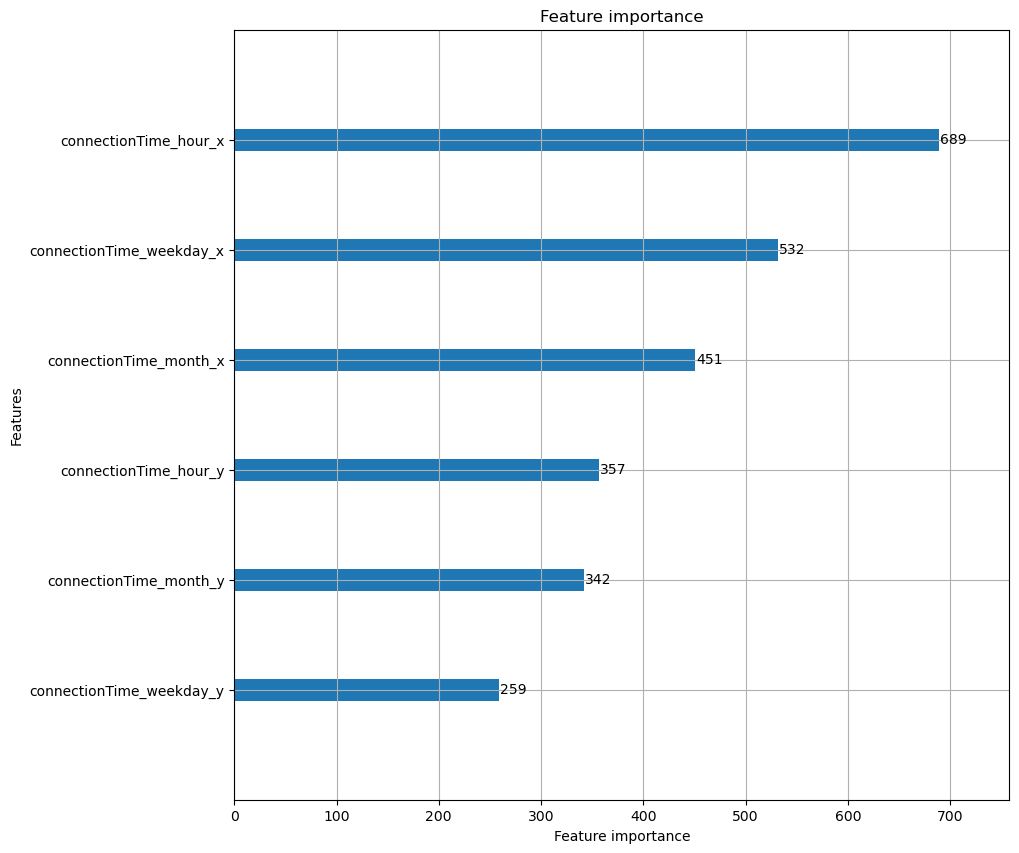

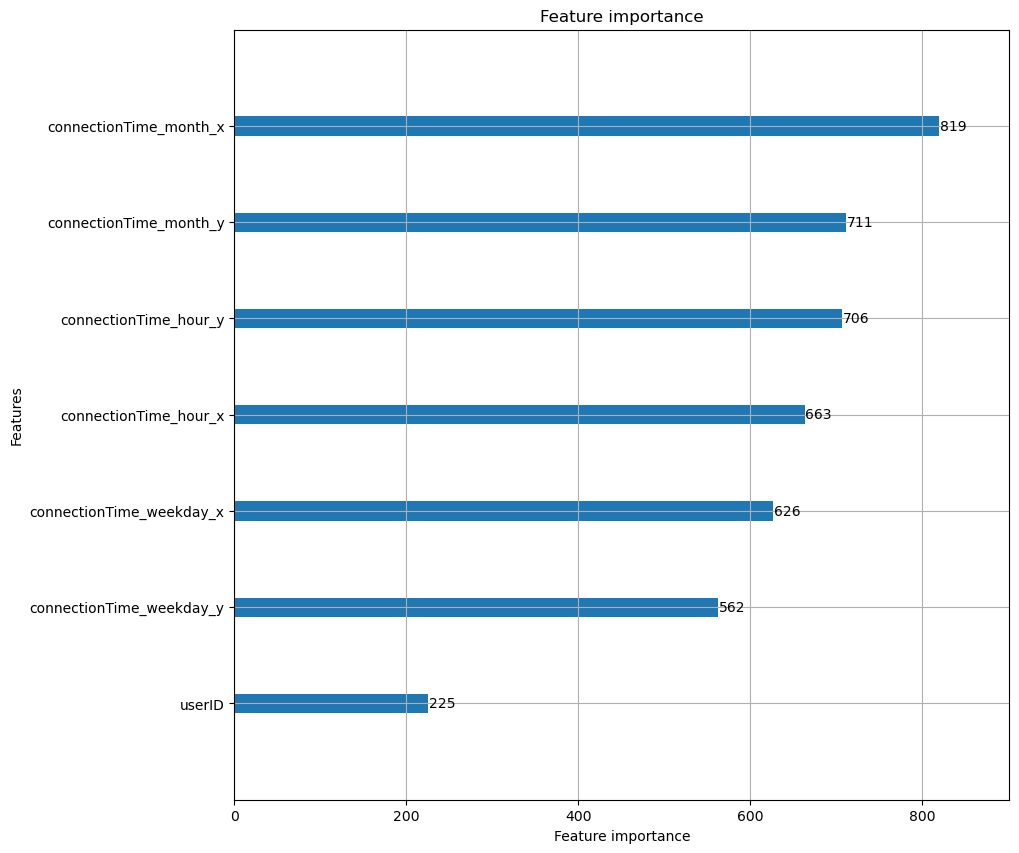

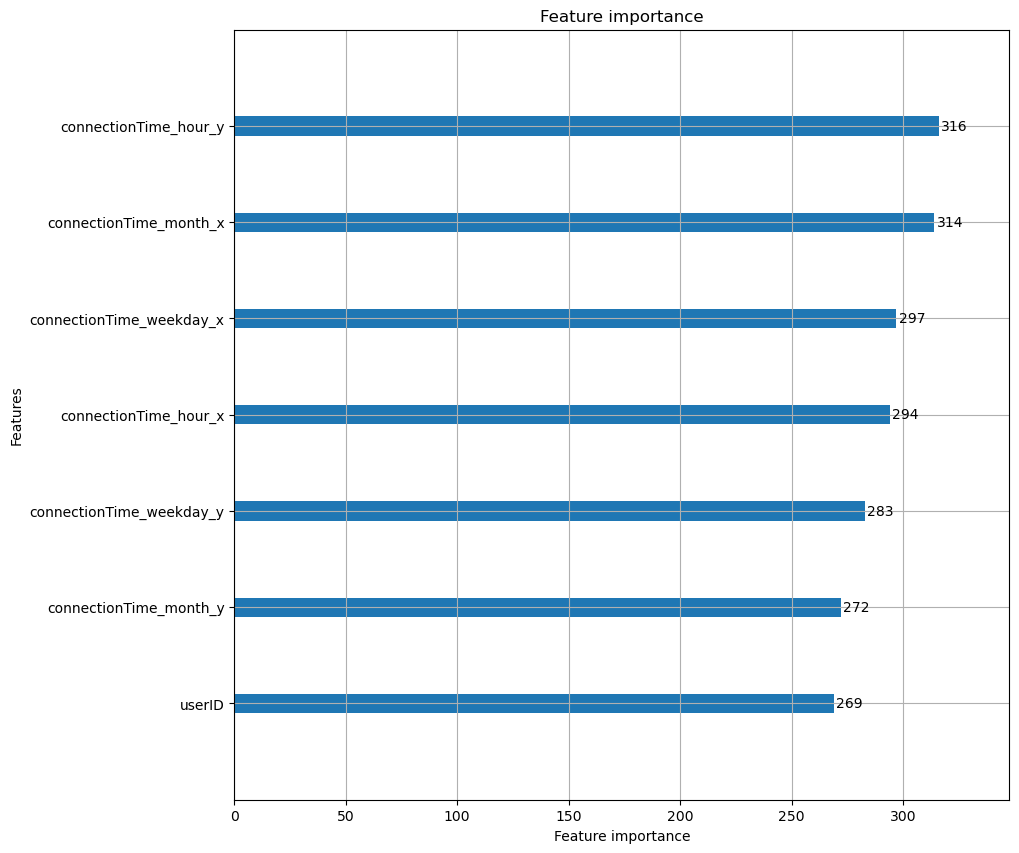

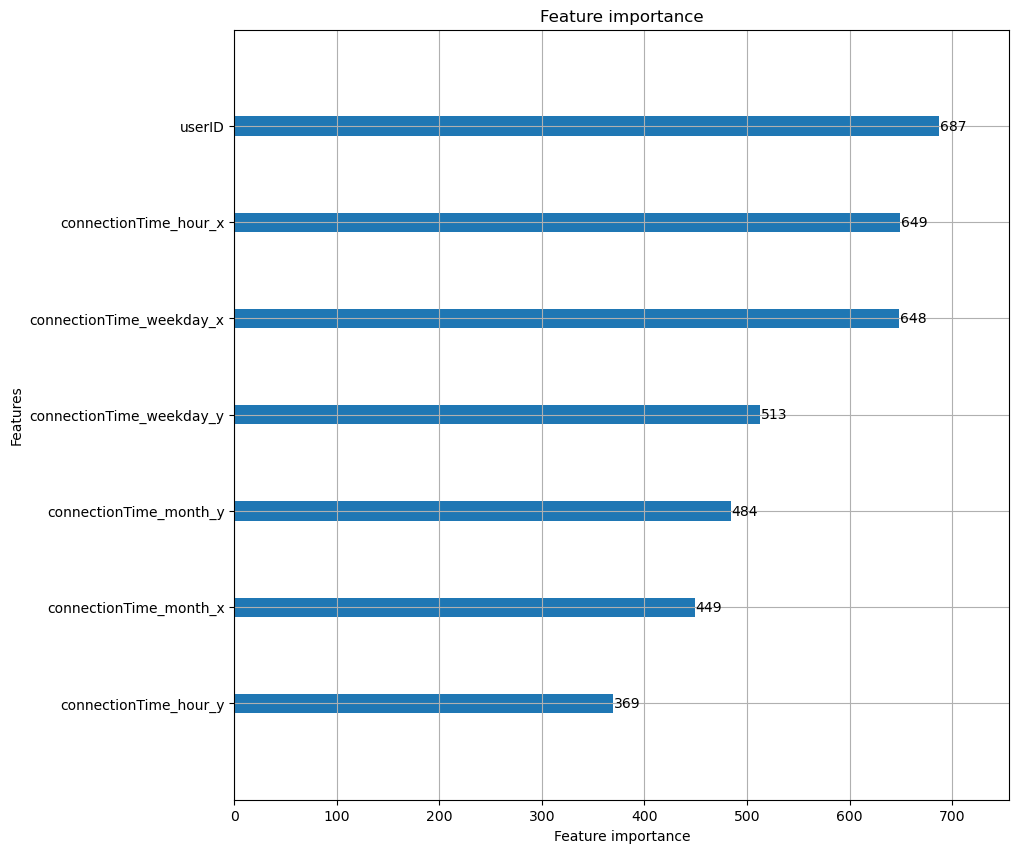

In [51]:
# feature importance of lightgbm model
def plot_feature_importance(model, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    lgb.plot_importance(model, ax=ax)
    plt.show()


# plot feature importance for each time interval
plot_feature_importance(model_0)
plot_feature_importance(model_1)
plot_feature_importance(model_2)
plot_feature_importance(model_3)
